In [1]:
%pip install transformers datasets tinygrad safetensors

  Using cached tinygrad-0.10.2-py3-none-any.whl.metadata (11 kB)
Using cached tinygrad-0.10.2-py3-none-any.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from blm.gpt import BytesGPT, BytesGPTConfig
from blm.gpt import encode,decode


In [ ]:

from datasets import Dataset

from blm.data import tokenize_fn

def get_local_dataset():
    import os
    import glob

    def load_files(path):
        texts = []
        for file_path in glob.glob(path):
            with open(file_path, "rb") as f:
                texts.append(f.read())
        return texts

    dummy_texts = load_files("/home/pkd/code/pst/raw/2020/*.txt")

    # split into 1024 bytes sections
    def split_text(text, chunk_size=512):
        return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    dummy_texts = [split_text(text) for text in dummy_texts]
    dummy_texts = [item for sublist in dummy_texts for item in sublist]
    # Create a Hugging Face Dataset from the list of sentences.
    dummy_dataset = Dataset.from_dict({"text": dummy_texts})


    tokenized_dataset = dummy_dataset.map(tokenize_fn, batched=False)
    tokenized_dataset = tokenized_dataset.to_dict()

    return {
        "train": tokenized_dataset
    }

def get_hf_dataset():
    from datasets import load_dataset
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

    # Function to split text into chunks of 512 characters
    def split_text(examples):
        chunk_size = 512
        all_chunks = []
        for text in examples["text"]:
            chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
            # Filter out empty chunks
            chunks = [chunk for chunk in chunks if chunk.strip()]
            all_chunks.extend(chunks)
        return {"text": all_chunks}

    # Split the texts first, then tokenize
    dataset = dataset.map(split_text, batched=True, batch_size=1000)
    tokenized_dataset = dataset.map(tokenize_fn, batched=True)
    tokenized_dataset = tokenized_dataset.to_dict()

    # Always return a dict with a "train" key for consistency with local
    return {"train": tokenized_dataset["train"]}



dataset="local"

tokenized_dataset = None
if dataset == "local":
    tokenized_dataset = get_local_dataset()
else:
    tokenized_dataset = get_hf_dataset()

train_tokenized_dataset = tokenized_dataset["train"]





Map:   0%|          | 0/7982 [00:00<?, ? examples/s]

In [4]:
# write some code to test cuda
import tinygrad
from tinygrad.tensor import Tensor


from blm.gpt import BytesGPT, BytesGPTConfig
from blm.data import Loader, collate_fn

config = BytesGPTConfig(
    vocab_size=255,        # Vocabulary size of GPT-2 tokenizer
    block_size=1024,

    n_embd=768,            # Embedding dimension
    n_head=16,           # Number of attention heads
    n_layer=4,           # Number of transformer layers
)

size = 10
# keep the 100 first dataset examples
train_tokenized_dataset = {k: v[:size] for k,v in train_tokenized_dataset.items()}

    
# test the loader
print(len(train_tokenized_dataset["input_ids"]))
loader = Loader(train_tokenized_dataset,  batch_size=1)

for batch in loader:
    for k,v in batch.items():
        print(k,v.numpy())
    break

print(len(loader))




10
input_ids [[ 76 101 115  32 112 105 101 100 115  32 115 117 114  32 116 101 114 114
  101  44  32  83 111 110 105  97  32  75 114 111 110 108 117 110 100  32
  101 116  32  68 101 108 112 104 105 110 101  32  83 101 108 116 101 108
   46  32  68 101 115  32 104 105 115 116 111 105 114 101 115  44  32 100
  101 115  32 101 110 113 117 195 170 116 101 115  44  32 100 101 115  32
  114 101 112 111 114 116  97 103 101 115  46  32  80  97 114  99 101  32
  113 117 101  32  99  39 101 115 116  32  99 111 109 109 101  32 195 167
   97  32 113 117 101  32 108 101 115  32  99 104 111 115 101 115  32  97
  114 114 105 118 101 110 116  46  32  85 110  32 101 110 100 114 111 105
  116  32 111 195 185  32 115 105  32 111 110  32 110  39 121  32 101 115
  116  32 112  97 115  44  32 111 110  32 109 101 117 114 116  46  32  67
   39 101 115 116  32  99 111 109 109 101  32  99 101 108  97  44  32  99
   97 115 104  44  32 115  97 110 115  32 112 105 110  99 101 116 116 101
  115  44  32 113 117 101

In [5]:

model = BytesGPT(config)
pretrained = True
if pretrained:
    gpt2_weights = tinygrad.nn.state.torch_load(tinygrad.fetch("https://huggingface.co/gpt2/resolve/main/pytorch_model.bin"))
    model.load_wheights(gpt2_weights)


ram used:  0.13 GB, lm_head.weight                                    : 100%|█| 


loaded weights in 376.94 ms, 0.13 GB loaded at 0.36 GB/s


In [9]:
from tinygrad.tensor import Tensor
from tinygrad.nn.optim import AdamW
from tinygrad import Device, TinyJit, GlobalCounters, nn

from time import sleep

Device.DEFAULT = "AMD"
print(Device.DEFAULT)

# Create an Adam optimizer
optim = AdamW(model.parameters(), lr=1e-6)

Tensor.training = True

from blm.train import cross_entropy_loss as loss_fn

@TinyJit
def step(model, batch):
    # Forward pass
    logits = model(batch["input_ids"], attention_mask=batch["attention_mask"])
    # Compute the loss
    loss = loss_fn(logits, batch["labels"], debug=False)
    # Backward pass
    optim.zero_grad()
    loss.backward()
    # Update the model parameters
    optim.step()
    return loss

# Train the model
for epoch in range(10):
    for i,batch in enumerate(loader):
        loss = step(model, batch)
        print(f"[{i}/{len(loader)}] Loss: {loss.item()}", end="\r")
    print()
    
    print(f"Epoch {epoch}: Loss {loss.item()}")
    loss_fn(model(batch["input_ids"], attention_mask=batch["attention_mask"]), batch["labels"], debug=True)



AMD
[9/10] Loss: nan010741233825684
Epoch 0: Loss nan
outputs: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
targets: [117 115  32  99  39 195 169 116  97 105 116  32 109 105 101 117 120  32
  97 118  97 110 116  46  32  77  97 105 115  32  99 111 109 109 101  32
  99  39 195 169 116  97 105 116  32 100 195 169 106 195 160  32 112  97
 115  32 116 101 114 114 105  98 108 101  32  97 118  97 110 116  44  32
 111 110  32 115 101  32 100 101 109  97 110 100 101  32 111 195 185  32
 101 115 116  45  99 101  32 113 117  39 111 110  32 118  97  44  32 113
 117 111 105  46  32  74 101  32 112 101 110 115 101  32 113 117 101  32
  99  39 101 115 116  32 100 101 115  32 109 195 169 116 105 101 114 115
  32 113 117  39 111 110  32 102  97 105 116  32 112  97 114  99 101  32
 113 117  39 111 110  32 108 101 115  32  97 105 109 101  46  32  74 101
  32 1

KeyboardInterrupt: 

[[ 83  97 108 117 116]]
0.9999997615814209
Token: S
1.0000001192092896
Token: a
1.0000001192092896
Token: l
1.000000238418579
Token: u
1.000000238418579
Token: t


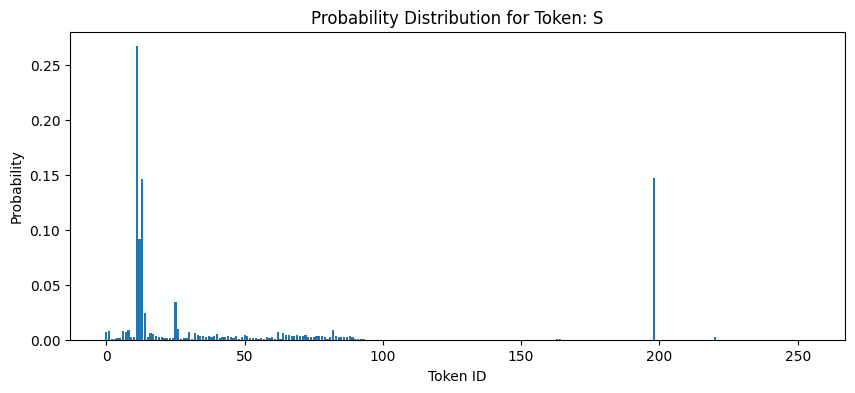

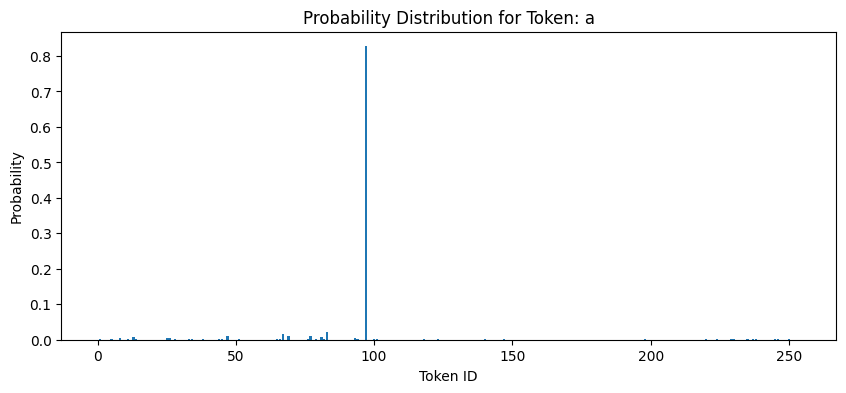

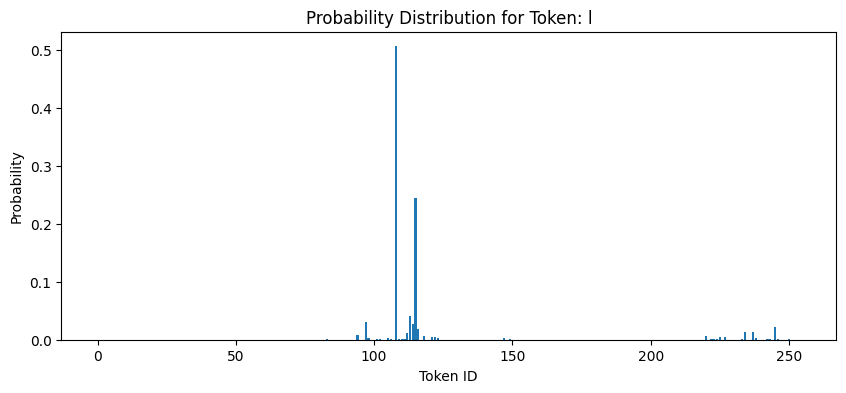

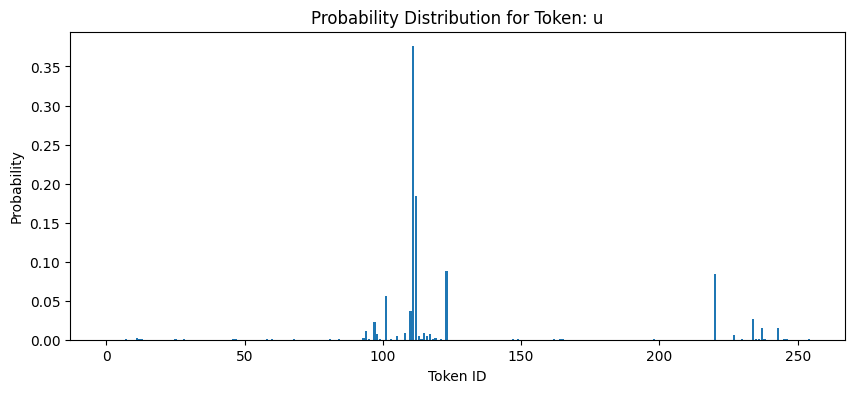

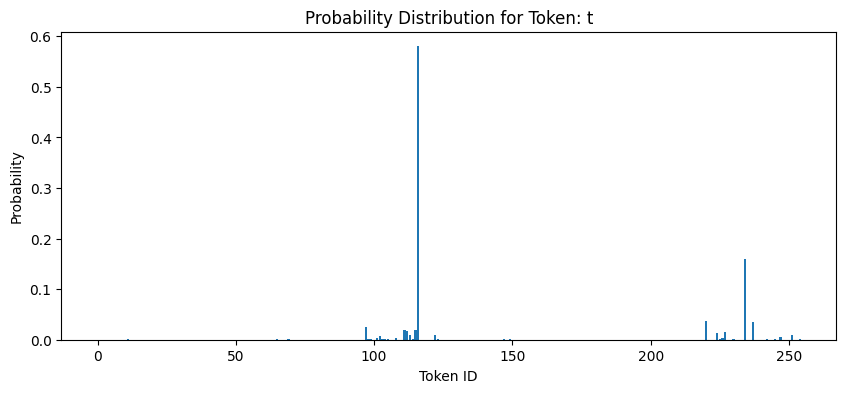

Total Entropy: 14.227804183959961
Total Perplexity: 43.84752655029297


In [7]:

import matplotlib.pyplot as plt

# tokenize the initial input sentence
input_ids = encode("Salut")
input_ids = Tensor(input_ids).reshape(1, -1)
print(input_ids.numpy())

probs = []

# generate probability distributions for all tokens in the input sentence
for i in range(len(input_ids[0])):
    logits = model(input_ids[:, :i+1])
    next_token_probs = logits.softmax()[0, -1]
    print(next_token_probs.sum().item())
    print("Token:", decode([input_ids[0][i].item()]))
    probs.append(next_token_probs)

# plot probability distributions
for i, prob in enumerate(probs):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(prob)), prob.numpy())
    plt.title(f"Probability Distribution for Token: {decode([input_ids[0][i].item()])}")
    plt.xlabel("Token ID")
    plt.ylabel("Probability")   

    plt.show()

# analyze entropy and perplexity
total_entropy = Tensor(0.0)
total_perplexity = Tensor(0.0)
for prob in probs:
    entropy = prob.log2().neg().mul(prob).sum()
    perplexity = entropy.exp2()
    total_entropy = total_entropy.add(entropy)
    total_perplexity = total_perplexity.add(perplexity)

print("Total Entropy:", total_entropy.item())
print("Total Perplexity:", total_perplexity.item())


In [8]:
# try some completion with our model

to_complete = "Je suis "


input_ids = encode(to_complete)
input_ids = Tensor(input_ids).unsqueeze(0)
outputs = model.generate(input_ids, max_new_tokens=100,  temperature=0.7)
completion = decode(outputs)
print(completion)

bad_model = BytesGPT(config)

bad_outputs = bad_model.generate(input_ids, max_new_tokens=100, temperature=0.7)
bad_completion = decode(bad_outputs)
print(bad_completion)





p
p
p
p
p
p
p
�
�
�
�
�
�
�
�
�
�
�
�
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a



D
P
C


A
A
P
P
P
E
E
P


KeyboardInterrupt: 

In [ ]:
model.save_weights("./gpt")

✨ Model saved in safetensors format at ./gpt.safetensors
